In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Вспомогательные фукнции

In [2]:
def func(x, t):
    """
    f(x,t) в исходном уравнении
    """
    return np.sin(x) + (2 * t) / (t ** 2 + 1)


def mu(t):
    """
    Граничные условия
    """
    return np.log(t ** 2 + 1)
    
    
def phi(x):
    """
    Начальные условия
    """
    return np.sin(x)


def init(N, T, h, delta):
    """
    Задание начальных и граничных условий
    """
    x = np.array([i * h for i in range(N + 1)])
    t = np.array([j * delta for j in range(T + 1)])
    U = np.zeros(shape=(N + 1, T + 1))
    U[:, 0] = phi(x)
    U[0, :] = mu(t.T)
    U[-1, :] = mu(t.T)
    return x, t, U


def real(x, t):
    """
    Форма точного решения
    """
    return np.sin(x) + np.log(t ** 2 + 1)


def exact(h, delta):
    """
    Точное решение
    """
    N = int(np.pi / h)
    T = int(5 / delta)
    x, t, _ = init(N, T, h, delta)
    U_real = np.zeros(shape=(N + 1, T + 1))
    for j in range(T + 1):
        for i in range(N + 1):
            U_real[i, j] = real(x[i], t[j])
    return x, t, U_real


#### Представление результата

In [3]:
def plot(t, x, U, title):    
    """
    Построение графика U(x, t)
    """
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    T, X = np.meshgrid(t, x)
    Z = U.T
    ax.plot_surface(T, X, Z, cmap="viridis", rstride=1, cstride=1, linewidth=0)    
    ax.view_init(30, 220);
    plt.suptitle(title)
    plt.show()

    
def error_max(U, h, delta):
    """
    Вычисление ошибки
    """
    x, t, U_real = exact(h, delta)
    return np.max(np.abs(U - U_real))


def error_shape(U, h, delta):
    """
    Нахождение формы ошибки
    """
    x, t, U_real = exact(h, delta)
    return np.abs(U - U_real)


def result(schema, title):
    """
    Сравнение результатов для разных 
    разбиений по x и t
    """
    _errors = []
    _steps = []
    _deltas = []
    steps = [np.pi / 5, np.pi / 10, np.pi / 20]
    deltas = [0.25, 0.10, 0.05]
    
    x, t, U = schema(steps[0], deltas[0])
    plot(x, t, U, title)
    plot(x, t, error_shape(U, steps[0], deltas[0]), title + "_error")
    
    for h in steps:
        for delta in deltas:
            x, t, U = schema(h, delta)
            err = error_max(U, h, delta)
            _errors.append(err)
            _steps.append(h)
            _deltas.append(delta)

    df = pd.DataFrame(data={
        "step": _steps, 
        "delta": _deltas,
        "error": _errors
    })
    return df

#### Реализация метода прогонки

In [4]:
def thomas_solver(a, b, c, d):
    """
    Метод прогонки
    """
    nf = len(d) 
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1] 
    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]
    return xc


### Точное решение

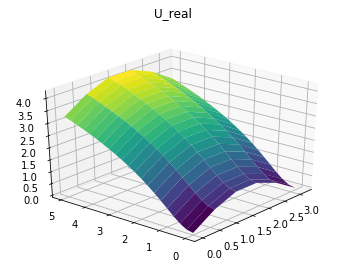

In [5]:
delta, h = 0.25, np.pi / 5
x, t, U_real = exact(h, delta)
plot(x, t, U_real, title="U_real")

### Явная схема

In [6]:
def explicit(h, delta):
    """
    Явная схема
    """
    N = int(np.pi / h)
    T = int(5 / delta)
    gamma = delta / h ** 2
    x, t, U = init(N, T, h, delta)
    
    for j in range(T):
        for i in range(1, N):
            U[i, j + 1] = ( 
                gamma * U[i - 1, j] + 
                (1 - 2 * gamma) * U[i, j] + 
                gamma * U[i + 1, j] + 
                delta * func(x[i], t[j])
            )
    return x, t, U

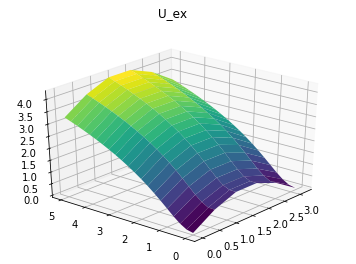

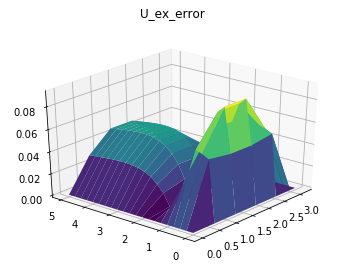

,delta,error,step
0,0.25,9.192398e-02,0.628319
1,0.10,3.834479e-02,0.628319
2,0.05,3.477613e-02,0.628319
3,0.25,1.797162e+15,0.314159
4,0.10,2.651419e+19,0.314159
5,0.05,1.581718e-02,0.314159
6,0.25,1.621452e+27,0.157080
7,0.10,3.945634e+53,0.157080
8,0.05,1.729154e+79,0.157080


In [7]:
result(explicit, "U_ex")

### Неявная схема

In [8]:
def implicit(h, delta):
    """
    Неявная схема
    """
    N = int(np.pi / h)
    T = int(5 / delta)
    gamma = delta / (h ** 2)
    x, t, U = init(N, T, h, delta)

    A = np.ones(shape=(N,)) * (- 1) * gamma
    B = np.ones(shape=(N + 1,)) * (1 + 2 * gamma)
    C = np.ones(shape=(N,)) * (- 1) * gamma
       
    for j in range(T):
        U[:, j + 1] = thomas_solver(
            A, B, C, 
            U[:, j] + delta * func(x, t[j + 1 ])
        )   
        U[0, j + 1] = mu(t[j + 1])
        U[-1, j + 1] = mu(t[j + 1])
    return x, t, U

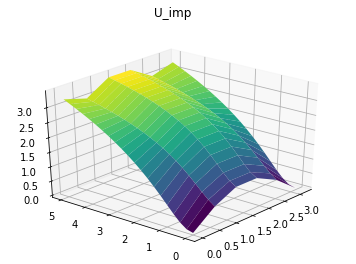

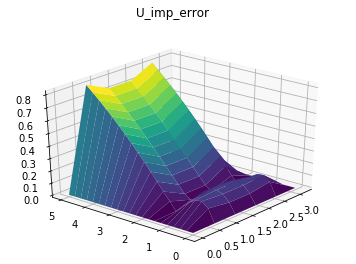

,delta,error,step
0,0.25,0.813996,0.628319
1,0.10,0.428016,0.628319
2,0.05,0.233174,0.628319
3,0.25,1.849810,0.314159
4,0.10,1.320258,0.314159
5,0.05,0.893717,0.314159
6,0.25,2.628594,0.157080
7,0.10,2.325528,0.157080
8,0.05,1.951488,0.157080


In [9]:
result(implicit, "U_imp")

### Схема Кранка-Никольсон

In [10]:
def crank_nickolson(h, delta):
    """
    Схема Кранка-Никольсон
    """
    N = int(np.pi / h)
    T = int(5 / delta)
    gamma = delta / (h ** 2)
    x, t, U = init(N, T, h, delta)

    A = np.ones(shape=(N,)) * (- 1 / 2) * gamma
    B = np.ones(shape=(N + 1,)) * (1 + gamma)
    C = np.ones(shape=(N,)) * (- 1 / 2) * gamma
    D = np.zeros(shape=(N + 1,))
    for j in range(T):
        for i in range(1, N):
            D[i] = U[i - 1, j] - 2 * U[i, j] + U[i + 1, j]
        U[:, j + 1] = thomas_solver(
                A, B, C, 
                U[:, j] + (1 / 2) * gamma * D + delta * func(x, t[j + 1])
            )    
        U[0, j + 1] = mu(t[j + 1])
        U[-1, j + 1] = mu(t[j + 1])
    return x, t, U

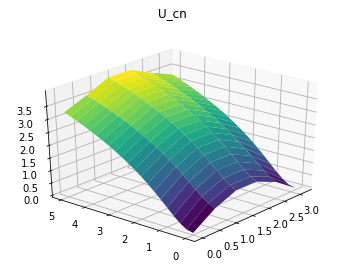

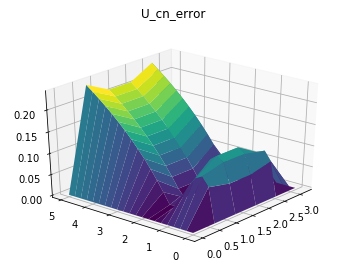

,delta,error,step
0,0.25,0.238102,0.628319
1,0.10,0.105801,0.628319
2,0.05,0.048224,0.628319
3,0.25,0.605955,0.314159
4,0.10,0.392975,0.314159
5,0.05,0.249137,0.314159
6,0.25,0.951145,0.157080
7,0.10,0.750840,0.157080
8,0.05,0.599772,0.157080


In [11]:
result(crank_nickolson, "U_cn")